# Analysis of adding back in the 6F for NIL for reprogramming

## Load data
Notes:

1. Only singlets are included

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import re
from pathlib import Path

# Required descriptors for annotate
from scipy.stats import ttest_ind
from statannotations.stats.StatTest import StatTest
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

custom_long_name = 't-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_less'
custom_func = ttest_ind
ttest_ind_less = StatTest(custom_func, custom_long_name, custom_short_name, alternative='less')

# Look at 4 dpi data

## Load data

In [3]:
# Directories
figpath = '../figures/fig4/'

# List of ctrls and samples
ctrl_list = ['Ctrl-RIDDW', 'Ctrl-puro']
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+B', 'NIL+A', 'NIL+M',
             'NIL+AB', 'NIL+BM', 'NIL+AM', 'NIL+ABM']

# Store all data in list of dfs which will be converted to df at end
data_4dpi_all = list()

# Directories
base_datadir = rd.datadir/'2023.02.15_HG_6F-addin_1-3_4dpi'
dir_list_1_3 = ['2023.02.15_HG_6F-addin_1', '2023.02.15_HG_6F-addin_2', '2023.02.28_HG_6F-addin_3']
# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list_1_3):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata.yaml')
    df['rep'] = j
    data_4dpi_all.append(df)

# Directories
base_datadir = rd.datadir/'2023.05.16_HG_6F-addin_4-7_4dpi'
dir_list_4_5 = ['2023.05.16_HG_6F-addin_4_4dpi', '2023.05.16_HG_6F-addin_5_4dpi']
# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list_4_5):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata_6F-addin-4-5.yaml')
    data_4dpi_all.append(df)

# Directories
dir_list_6_7 = ['2023.05.23_HG_6F-addin_6_4dpi', '2023.05.23_HG_6F-addin_7_4dpi']
# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list_6_7):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata_6F-addin-6-7.yaml')
    data_4dpi_all.append(df)

# Convert list of dfs into single df
data_4dpi_all = pd.concat(data_4dpi_all, ignore_index=True)

# Remove negative data
data_4dpi_all = data_4dpi_all.loc[
    (data_4dpi_all['FSC-A'] > 0) &
    (data_4dpi_all['SSC-A'] > 0) &
    (data_4dpi_all['eGFP-A'] > 0) &
    (data_4dpi_all['CellTrace-FarRed-A'] > 0)
]

# Separate out ctrl and sample data
data_4dpi_ctrl = data_4dpi_all[ data_4dpi_all['cond'].isin(ctrl_list) ]
data_4dpi = data_4dpi_all[ data_4dpi_all['cond'].isin(cond_list) ]

## Categorize cells
### Categorize cells based on CellTrace-FarRed

In [4]:
# Get CTFR-low threshold for each rep s.t.
# CTFR_low_thresh = 20% dimmest in ctrl
rep_list = data_4dpi.rep.unique()
CTFR_low_thresh_list = np.zeros(np.shape(rep_list))
for (i, rep) in enumerate(rep_list):
    CTFR_low_thresh_list[i] = np.percentile(
        data_4dpi.loc[(data_4dpi['cond'] == 'Ctrl-puro') &
            (data_4dpi['rep'] == rep)
        ]['CellTrace-FarRed-A'], 20)

# Categorize based on CTFR for each rep
data_4dpi['CTFR_cat'] = 'CTFR-low'
for (i, rep) in enumerate(rep_list):
    data_4dpi.loc[
        (data_4dpi['rep'] == rep_list[i]) &
        (data_4dpi['CellTrace-FarRed-A'] > CTFR_low_thresh_list[i]),
        'CTFR_cat'] = 'non-CTFR-low'

# Calculate CTFR populations using these metrics
well_group = ['rep', 'cond']
count_df_reps = data_4dpi.groupby([*well_group, 'well', 'CTFR_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if none rather than dropping row
CTFR_percent_4dpi_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']
                           ).transform('sum')).reset_index(name='percent')

# Extract just the hyperP
CTFR_hyperP_count_4dpi_reps = (count_df_reps).reset_index(name='count')
CTFR_hyperP_count_4dpi_reps = CTFR_hyperP_count_4dpi_reps.loc[(CTFR_hyperP_count_4dpi_reps['CTFR_cat'] == 'CTFR-low')]
seedNum = 10**4 # Seeded 10k MEFs/96-well
CTFR_hyperP_yield_4dpi_reps = (count_df_reps*100/seedNum).reset_index(name='yield')
CTFR_hyperP_yield_4dpi_reps = CTFR_hyperP_yield_4dpi_reps.loc[(CTFR_hyperP_yield_4dpi_reps['CTFR_cat'] == 'CTFR-low')]
CTFR_hyperP_percent_4dpi_reps = CTFR_percent_4dpi_reps.loc[(CTFR_percent_4dpi_reps['CTFR_cat'] == 'CTFR-low')]

# Reduce to bio reps
CTFR_hyperP_percent_4dpi = CTFR_hyperP_percent_4dpi_reps.groupby(well_group)['percent'].mean().reset_index()
CTFR_hyperP_yield_4dpi = CTFR_hyperP_yield_4dpi_reps.groupby(well_group)['yield'].mean().reset_index()
CTFR_hyperP_count_4dpi = CTFR_hyperP_count_4dpi_reps.groupby(well_group)['count'].mean().reset_index()

/var/folders/2d/h4qyrjcd68x7g4p2qdv30s8h0000gn/T/ipykernel_48259/3982590643.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_4dpi['CTFR_cat'] = 'CTFR-low'
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


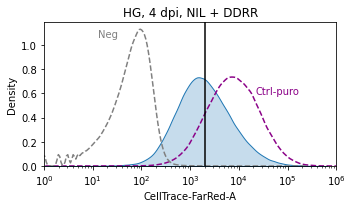

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

rep = 1
CTFR_low_thresh = CTFR_low_thresh_list[rep-1]

# Plot
x = 'CellTrace-FarRed-A'
sns.kdeplot(data=data_4dpi.loc[
    (data_4dpi['cond'] == 'NIL') & (data_4dpi['rep'] == rep)],
    ax=ax, x=x,
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot CTFR control
sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-puro')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='#8b0288', fill=False, linestyle='--')
ax.annotate('Ctrl-puro', (0.8, 0.5), color='#8b0288' , xycoords='axes fraction', ha='center')

# Plot neg ctrl
sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-RIDDW')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.22, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(CTFR_low_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, NIL + DDRR')
# Adjust limits
CTFR_lim = (1, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(CTFR_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing

### Categorize cells based on eGFP

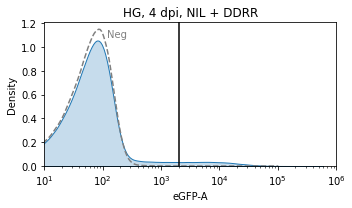

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Threshold for early eGFP+
eGFP_A_thresh = 2*10**3

# Plot eGFP-A
x = 'eGFP-A'
sns.kdeplot(data=data_4dpi.loc[(data_4dpi['cond'] == 'NIL')],
        ax=ax, x=x,
        common_norm=False, log_scale=(True, False),
        fill=True)

# Plot neg ctrl
sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-RIDDW')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.25, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(eGFP_A_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, NIL + DDRR')
# Adjust limits
eGFP_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing

In [11]:
# Categorize eGFP+ based on eGFP_thresh
data_4dpi['eGFP_cat'] = 'eGFP-'
data_4dpi.loc[(data_4dpi['eGFP-A'] > eGFP_A_thresh), 'eGFP_cat'] = 'eGFP+'

# Get total counts and percent of GFP-H+
well_group = ['rep', 'cond']
count_df_reps = data_4dpi.groupby([*well_group, 'well', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no GFP-H+ rather than dropping row # Try size ??
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']).transform('sum')).reset_index(name='percent')

# Extract just the eGFP+
data_4dpi_eGFP_percent_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'eGFP+')]
data_4dpi_eGFP_percent = data_4dpi_eGFP_percent_reps.groupby(well_group)['percent'].mean().reset_index()

/var/folders/2d/h4qyrjcd68x7g4p2qdv30s8h0000gn/T/ipykernel_48259/700139258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_4dpi['eGFP_cat'] = 'eGFP-'


## Plot eGFP at 4 dpi

Text(0.5, 0, '(%) Hb9::GFP+\nof all cells at 4 dpi')

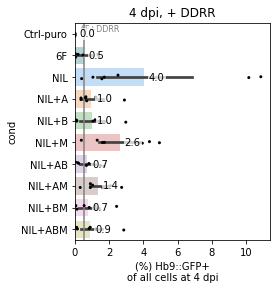

In [13]:
# General plotting params
y = 'cond'
x = 'percent'
marker_list = ['o', 's', '^', 'D']
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+A', 'NIL+B', 'NIL+M',
             'NIL+AB', 'NIL+AM', 'NIL+BM', 'NIL+ABM']
palette = {
    'Ctrl-puro':'grey', 'NIL':'dodgerblue', '6F':'teal',
    'NIL+A':'tab:orange', 'NIL+B':'tab:green', 'NIL+M':'tab:red',
    'NIL+AB':'tab:purple', 'NIL+AM':'tab:brown', 'NIL+BM':'tab:pink',
    'NIL+ABM':'tab:olive'}

fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))

# Plot eGFP+ percent of all cells
sns.barplot(ax=ax, data=data_4dpi_eGFP_percent,
            x=x, y=y, order=cond_list, palette=palette,
            alpha=0.3, orient='h')
sns.stripplot(ax=ax, data=data_4dpi_eGFP_percent,
              x=x, y=y, order=cond_list,
              dodge=True, color='black', size=3, orient='h')

# Plot avg for 6F
avg_6FDDRR_eGFP_percent = np.mean(
    data_4dpi_eGFP_percent.loc[(data_4dpi_eGFP_percent['cond'] == '6F')]['percent'])
ax.axvline(avg_6FDDRR_eGFP_percent, 0, 1, color='grey')
ax.annotate('6F+DDRR', (0.03, 0.96),
    xycoords='axes fraction', ha='left', color='grey', fontsize=8)

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.1f', padding=5)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
ax.set_title('4 dpi, + DDRR')
ax.xaxis.set_label_text('(%) Hb9::GFP+\nof all cells at 4 dpi')

## Look at HyperP at 4 dpi

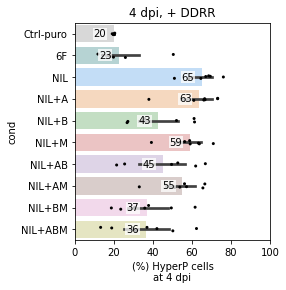

In [ ]:
# General plotting params
y = 'cond'
x = 'percent'
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+A', 'NIL+B', 'NIL+M',
             'NIL+AB', 'NIL+AM', 'NIL+BM', 'NIL+ABM']
palette = {
    'Ctrl-puro':'grey', 'NIL':'dodgerblue', '6F':'teal',
    'NIL+A':'tab:orange', 'NIL+B':'tab:green', 'NIL+M':'tab:red',
    'NIL+AB':'tab:purple', 'NIL+AM':'tab:brown', 'NIL+BM':'tab:pink',
    'NIL+ABM':'tab:olive'}

fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))

# Plot eGFP+ percent of all cells
color='limegreen'
sns.barplot(ax=ax, data=CTFR_hyperP_percent_4dpi,
            x=x, y=y, order=cond_list, palette=palette,
            alpha=0.3, orient='h')
sns.stripplot(ax=ax, data=CTFR_hyperP_percent_4dpi,
              x=x, y=y, order=cond_list,
              dodge=True, color='black', size=3, orient='h')

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=-20)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
ax.set_title('4 dpi, + DDRR')
ax.xaxis.set_label_text('(%) HyperP cells\nat 4 dpi')
ax.set_xticks(np.arange(0, 110, 20))

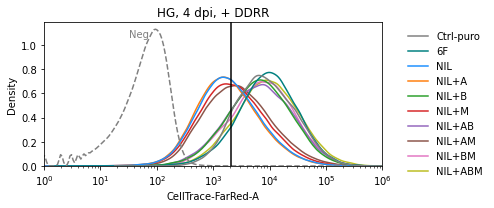

In [15]:
# Plotting params
x = 'CellTrace-FarRed-A'
hue = 'cond'
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+A', 'NIL+B', 'NIL+M',
             'NIL+AB', 'NIL+AM', 'NIL+BM', 'NIL+ABM']
palette = {
    'Ctrl-puro':'grey', 'NIL':'dodgerblue', '6F':'teal',
    'NIL+A':'tab:orange', 'NIL+B':'tab:green', 'NIL+M':'tab:red',
    'NIL+AB':'tab:purple', 'NIL+AM':'tab:brown', 'NIL+BM':'tab:pink',
    'NIL+ABM':'tab:olive'}

# Threshold for iMNs
rep = 1
CTFR_low_thresh = CTFR_low_thresh_list[rep-1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

g = sns.kdeplot(data=data_4dpi.loc[(data_4dpi['rep'] == rep)],
    ax=ax, x=x, hue=hue, hue_order=cond_list, palette=palette,
    common_norm=False, log_scale=(True, False),
    fill=False)
sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1.05,1), frameon=False)
# g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Plot neg ctrl
sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-RIDDW')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.28, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(CTFR_low_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, + DDRR')
# Adjust limits
CTFR_lim = (1, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(CTFR_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing
# plt.savefig(figpath + '4dpi_CTFR_dist_all.svg', bbox_inches='tight')

#### Look at Hb9::GFP+ in hyperP vs. non

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL+ABM_CTFR-low vs. NIL+ABM_non-CTFR-low: t-test independent samples with Bonferroni correction, P_val:9.944e-01 t=1.682e+00
NIL+BM_CTFR-low vs. NIL+BM_non-CTFR-low: t-test independent samples with Bonferroni correction, P_val:8.188e-02 t=2.764e+00
6F_CTFR-low vs. 6F_non-CTFR-low: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.246e+00
Ctrl-puro_CTFR-low vs. Ctrl-puro_non-CTFR-low: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.598e+00
NIL_CTFR-low vs. NIL_non-CTFR-low: t-test independent samples with Bonferroni correction, P_val:4.208e-02 t=3.012e+00
NIL+A_CTFR-low vs. NIL+A_non-CTFR-low: t-test independent samples with Bonferroni correction, P_val:1.875e-02 t=3.300e+00
NIL+B_CTFR-low vs. NIL+B_non-CTFR-low: t-test independent samples with Bonferroni

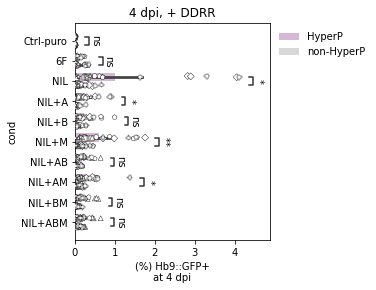

In [38]:
# Plotting params
y = 'cond'
x = 'percent'
hue = 'CTFR_cat'
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+A', 'NIL+B', 'NIL+M',
             'NIL+AB', 'NIL+AM', 'NIL+BM', 'NIL+ABM']
hue_order = ['CTFR-low', 'non-CTFR-low']
colormap = {'CTFR-low': '#8b0288',
            'non-CTFR-low': 'grey'}
marker_list = ['o', 's', '^', 'D', 'p', '*', 'P']
units = 'well'

# Calculate CTFR -> eGFP populations
grouping = ['rep', 'cond']
count_df_reps = data_4dpi.groupby([*grouping, 'well', 'CTFR_cat', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if none rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby(grouping
                           ).transform('sum')).reset_index(name='percent')
# Extract just the eGFP
CTFR_eGFP_percent_4dpi_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'eGFP+')]
# Collapse to bio reps
CTFR_eGFP_percent_4dpi = CTFR_eGFP_percent_4dpi_reps.groupby([*grouping, 'CTFR_cat', 'eGFP_cat'])['percent'].mean().reset_index()

# Plot iMN percent of all cells
fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))
sns.barplot(ax=ax, data=CTFR_eGFP_percent_4dpi_reps,
            x=x, y=y, order=cond_list,
            hue=hue, hue_order=hue_order, units=units,
            palette=colormap,
            alpha=0.3, orient='h')

for (i, rep) in enumerate(CTFR_eGFP_percent_4dpi_reps.rep.unique()):
    sns.stripplot(ax=ax, data=CTFR_eGFP_percent_4dpi_reps.loc[(CTFR_eGFP_percent_4dpi_reps.rep == rep)],
        x=x, y=y, order=cond_list, hue=hue, hue_order=hue_order,
        dodge=True, marker=marker_list[i],
        palette={'CTFR-low': 'white', 'non-CTFR-low': 'white'}, size=5, orient='h',
        edgecolor='black', linewidth=0.4,)

# Adjust legend
lmap = {'CTFR-low':'HyperP', 'non-CTFR-low':'non-HyperP'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Pairs for stats comp
pairs = [ ((cond, 'CTFR-low'), (cond, 'non-CTFR-low')) for cond in cond_list]
# Add in stats for eGFP percent
annot = Annotator(ax=ax, data=CTFR_eGFP_percent_4dpi_reps,
    x=x, y=y, pairs=pairs, hue=hue,
    order=cond_list, hue_order=hue_order, orient='h')
annot.configure(test='t-test_ind', comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

ax.set_title('4 dpi, + DDRR')
ax.xaxis.set_label_text('(%) Hb9::GFP+\nat 4 dpi')
# plt.savefig(figpath + 'SI/4dpi_eGFP+byCTFR_hor.svg', bbox_inches='tight')

#### Look at Brn2 effects

In [17]:
# Build Brn2 paired version
brn2_hyperP_yield_reps = CTFR_hyperP_yield_4dpi_reps.copy()
brn2_hyperP_yield_reps.drop(brn2_hyperP_yield_reps[brn2_hyperP_yield_reps.cond == 'Ctrl-puro'].index, inplace=True)
brn2_hyperP_yield_reps.drop(brn2_hyperP_yield_reps[brn2_hyperP_yield_reps.cond == '6F'].index, inplace=True)

paired_map = {
    'NIL':('NIL', '– Brn2'),
    'NIL+B':('NIL', '+ Brn2'),
    'NIL+A':('NIL+A', '– Brn2'),
    'NIL+AB':('NIL+A', '+ Brn2'),
    'NIL+M':('NIL+M', '– Brn2'),
    'NIL+BM':('NIL+M', '+ Brn2'),
    'NIL+AM':('NIL+AM', '– Brn2'),
    'NIL+ABM':('NIL+AM', '+ Brn2'),
}

for index, row in brn2_hyperP_yield_reps.iterrows():
    brn2_hyperP_yield_reps.loc[index, 'main_cond'] = paired_map[row.cond][0]
    brn2_hyperP_yield_reps.loc[index, 'Brn2_cat'] = paired_map[row.cond][1]

# Convert yield to count (yield = count/seedNum*100)
brn2_hyperP_yield_reps['count'] = brn2_hyperP_yield_reps['yield']/100*seedNum

# Calc mean and SEM for each cond
grouping = [ 'cond', 'Brn2_cat']
brn2_hyperP_yield_mean = brn2_hyperP_yield_reps.groupby(grouping).mean().reset_index()
brn2_hyperP_yield_SEM = brn2_hyperP_yield_reps.groupby(grouping).sem().reset_index()

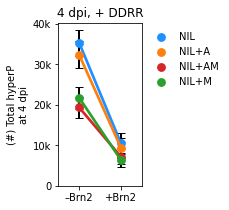

In [ ]:
# General plotting params
x = 'Brn2_cat'
y = 'count'
order = ['NIL', 'NIL+A', 'NIL+M', 'NIL+AM']
hue = 'main_cond'
# palette = {'': 'grey', '+B': 'dodgerblue'}
palette = {
    'NIL':'dodgerblue', 'NIL+A':'tab:orange',
    'NIL+M':'tab:green', 'NIL+AM':'tab:red',}

fig, ax = plt.subplots(1, 1, figsize=(1.5, 3))

sns.pointplot(
    ax=ax, data=brn2_hyperP_yield_reps,
    x=x, y=y, hue=hue, 
    ci=None,
    palette=palette,
    capsize=0.1, errwidth=2)

ax.errorbar(x=brn2_hyperP_yield_mean[x], y=brn2_hyperP_yield_mean[y],
            yerr=brn2_hyperP_yield_SEM[y],
            color='None', ecolor='black', elinewidth=2, capsize=4, zorder=-1)

sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format
ax.set_title('4 dpi, + DDRR')
ax.yaxis.set_label_text('(#) Total hyperP\nat 4 dpi')
ax.xaxis.set_label_text('')
ax.xaxis.set_ticklabels(['–Brn2', '+Brn2'])
ax.set_xlim((-0.5, 1.5)) # f = ax.get_xlim()
ax.set_yticks(np.arange(0, 4+.1, 1)*10**4)
k_formatter = FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.yaxis.set_major_formatter(k_formatter)

# plt.savefig(figpath + '4dpi_hyperPcount_Brn2cat_compact.svg', bbox_inches='tight')

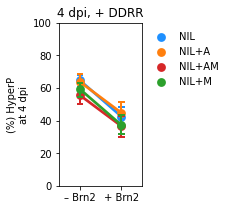

In [ ]:
CTFR_hyperP_percent_4dpi_reps

# Build Brn2 paired version
brn2_hyperP_percent_reps = CTFR_hyperP_percent_4dpi_reps.copy()
brn2_hyperP_percent_reps.drop(brn2_hyperP_percent_reps[brn2_hyperP_percent_reps.cond == 'Ctrl-puro'].index, inplace=True)
brn2_hyperP_percent_reps.drop(brn2_hyperP_percent_reps[brn2_hyperP_percent_reps.cond == '6F'].index, inplace=True)

paired_map = {
    'NIL':('NIL', '– Brn2'),
    'NIL+B':('NIL', '+ Brn2'),
    'NIL+A':('NIL+A', '– Brn2'),
    'NIL+AB':('NIL+A', '+ Brn2'),
    'NIL+M':('NIL+M', '– Brn2'),
    'NIL+BM':('NIL+M', '+ Brn2'),
    'NIL+AM':('NIL+AM', '– Brn2'),
    'NIL+ABM':('NIL+AM', '+ Brn2'),
}

for index, row in brn2_hyperP_percent_reps.iterrows():
    brn2_hyperP_percent_reps.loc[index, 'main_cond'] = paired_map[row.cond][0]
    brn2_hyperP_percent_reps.loc[index, 'Brn2_cat'] = paired_map[row.cond][1]

# General plotting params
x = 'Brn2_cat'
y = 'percent'
order = ['NIL', 'NIL+A', 'NIL+M', 'NIL+AM']
hue = 'main_cond'
# palette = {'': 'grey', '+B': 'dodgerblue'}
palette = {
    'NIL':'dodgerblue', 'NIL+A':'tab:orange',
    'NIL+M':'tab:green', 'NIL+AM':'tab:red',}

fig, ax = plt.subplots(1, 1, figsize=(1.5, 3))

sns.pointplot(
    ax=ax, data=brn2_hyperP_percent_reps,
    x=x, y=y, hue=hue, 
    palette=palette,
    capsize=0.1, errwidth=2)

sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format
ax.set_title('4 dpi, + DDRR')
ax.yaxis.set_label_text('(%) HyperP\nat 4 dpi')
ax.set_yticks(np.arange(0, 110, 20))
ax.xaxis.set_label_text('')

## Plot eGFP vs. HyperP at 4 dpi
### View all

In [20]:
percent_4dpi_reps = CTFR_hyperP_percent_4dpi_reps.rename(columns={"percent":"hyperP_percent"}, copy=True)
percent_4dpi_reps.drop(columns='CTFR_cat', inplace=True)

for index, row in percent_4dpi_reps.iterrows():

    hyperP_yield = CTFR_hyperP_yield_4dpi_reps.loc[
        (CTFR_hyperP_yield_4dpi_reps['rep']==row.rep) & 
        (CTFR_hyperP_yield_4dpi_reps['well']==row.well) & 
        (CTFR_hyperP_yield_4dpi_reps['cond']==row.cond)
        ]['yield']
    percent_4dpi_reps.loc[index, 'hyperP_yield'] = float(hyperP_yield)

    hyperP_count = CTFR_hyperP_count_4dpi_reps.loc[
        (CTFR_hyperP_count_4dpi_reps['rep']==row.rep) & 
        (CTFR_hyperP_count_4dpi_reps['well']==row.well) & 
        (CTFR_hyperP_count_4dpi_reps['cond']==row.cond)
        ]['count']
    percent_4dpi_reps.loc[index, 'hyperP_count'] = float(hyperP_count)

    eGFP_percent = data_4dpi_eGFP_percent_reps.loc[
        (data_4dpi_eGFP_percent_reps['rep']==row.rep) & 
        (data_4dpi_eGFP_percent_reps['well']==row.well) & 
        (data_4dpi_eGFP_percent_reps['cond']==row.cond)
        ]['percent']
    percent_4dpi_reps.loc[index, 'eGFP_percent'] = float(eGFP_percent)

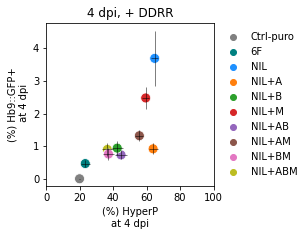

In [ ]:
# Calc mean and SEM for each cond
grouping = ['cond']
percent_4dpi_mean = percent_4dpi_reps.groupby(grouping).mean(numeric_only=True).reset_index()
percent_4dpi_SEM = percent_4dpi_reps.groupby(grouping).sem().reset_index()

# Plotting params
x = 'hyperP_percent'
y = 'eGFP_percent'
hue = 'cond'
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+A', 'NIL+B', 'NIL+M',
             'NIL+AB', 'NIL+AM', 'NIL+BM', 'NIL+ABM']
palette = {
    'Ctrl-puro':'grey', 'NIL':'dodgerblue', '6F':'teal',
    'NIL+A':'tab:orange', 'NIL+B':'tab:green', 'NIL+M':'tab:red',
    'NIL+AB':'tab:purple', 'NIL+AM':'tab:brown', 'NIL+BM':'tab:pink',
    'NIL+ABM':'tab:olive'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.errorbar(x=percent_4dpi_mean[x], y=percent_4dpi_mean[y],
            xerr=percent_4dpi_SEM[x], yerr=percent_4dpi_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)
            
f = sns.scatterplot(ax=ax,
    data=percent_4dpi_mean,
    x=x, y=y, hue=hue, hue_order=cond_list,
    s=100, palette=palette)

sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_xticks(np.arange(0, 110, 20))
ax.xaxis.set_label_text('(%) HyperP\nat 4 dpi')
ax.yaxis.set_label_text('(%) Hb9::GFP+\n at 4 dpi')
plt.title('4 dpi, + DDRR')

# plt.savefig(figpath + 'SI/4dpi_eGFP_v_hyperP.svg', bbox_inches='tight')

# Look at 14 dpi data

## Load 14 dpi data

In [22]:
# List of ctrls and samples
ctrl_list = ['Ctrl-RIDDW', 'Ctrl-puro']
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+B', 'NIL+A', 'NIL+M',
             'NIL+AB', 'NIL+BM', 'NIL+AM', 'NIL+ABM']

# Store all data in list of dfs which will be converted to df at end
data_14dpi_all = list()

# Directories
base_datadir = rd.datadir/'2023.02.25_HG_6F-addin_1-3_14dpi'
dir_list_1_3 = ['2023.02.25_HG_6F-addin_1_14dpi', '2023.02.25_HG_6F-addin_2_14dpi', '2023.03.10_HG_6F-addin_3_14dpi']
# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list_1_3):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata.yaml')
    df['rep'] = j
    data_14dpi_all.append(df)

# Directories
base_datadir = rd.datadir/'2023.05.26_HG_6F-addin_4-7_14dpi'
dir_list_4_5 = ['2023.05.26_HG_6F-addin_4_14dpi', '2023.05.26_HG_6F-addin_5_14dpi']
# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list_4_5):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata_6F-addin-4-5.yaml')
    data_14dpi_all.append(df)

# Directories
dir_list_6_7 = ['2023.06.02_HG_6F-addin_6_14dpi', '2023.06.02_HG_6F-addin_7_14dpi']
# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list_6_7):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata_6F-addin-6-7.yaml')
    data_14dpi_all.append(df)

# Convert list of dfs into single df
data_14dpi_all = pd.concat(data_14dpi_all, ignore_index=True)

# Remove negative data
data_14dpi_all = data_14dpi_all.loc[
    (data_14dpi_all['FSC-A'] > 0) &
    (data_14dpi_all['SSC-A'] > 0) &
    (data_14dpi_all['eGFP-A'] > 0)]

# Separate out ctrl and sample data
data_14dpi_ctrl = data_14dpi_all[ data_14dpi_all['cond'].isin(ctrl_list) ]
data_14dpi = data_14dpi_all[ data_14dpi_all['cond'].isin(cond_list) ]

## Look at eGFP for NILDDRR to determine eGFP gate

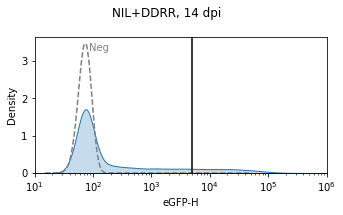

In [23]:
# Threshold for iMNs
eGFP_H_thresh = 5*10**3

# Downsample to 100,000 cells from NIL
small_data = data_14dpi[(data_14dpi['cond'] == 'NIL')].sample(n=10**5, random_state=1)
# small_data = data[(data['cond'] == 'NIL') & (
#     data['HIP_cat'] == True)].sample(n=10**5, random_state=1)

# Plot eGFP-H
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = 'eGFP-H'
sns.kdeplot(data=small_data, x=x,
            ax=ax, log_scale=(True, False), fill=True, common_norm=False)

# Plot neg ctrl
sns.kdeplot(data=data_14dpi_ctrl[(data_14dpi_ctrl['cond'] == 'Ctrl-RIDDW')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.22, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Title
plt.suptitle('NIL+DDRR, 14 dpi')
# Adjust limits
eGFP_lim = (10, 10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)
    sub_ax.axvline(eGFP_H_thresh, 0, 1, color='black')

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing
# plt.savefig(figpath + '14dpi_eGFP_dist.svg')

In [24]:
# Categorize iMNs based on eGFP_thresh
data_14dpi.loc[:, 'eGFP_cat'] = 'fib'
data_14dpi.loc[(data_14dpi['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of GFP-H+
well_group = ['rep', 'cond']
count_df_reps = data_14dpi.groupby([*well_group, 'well', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no GFP-H+ rather than dropping row

# Get iMN count, yield, percent per condition
seedNum = 10**4 # Seeded 10k MEFs/96-well
data_iMN_count_reps = (count_df_reps).reset_index(name='count')
data_iMN_yield_reps = (count_df_reps*100/seedNum).reset_index(name='yield')
data_iMN_percent_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']).transform('sum')).reset_index(name='percent')

# Extract just the iMNs
data_iMN_count_reps = data_iMN_count_reps.loc[(data_iMN_count_reps['eGFP_cat'] == 'iMN')]
data_iMN_yield_reps = data_iMN_yield_reps.loc[(data_iMN_yield_reps['eGFP_cat'] == 'iMN')]
data_iMN_percent_reps = data_iMN_percent_reps.loc[(data_iMN_percent_reps['eGFP_cat'] == 'iMN')]

# Reduce to bio reps
data_iMN_count = data_iMN_count_reps.groupby(well_group)['count'].mean().reset_index()
data_iMN_yield = data_iMN_yield_reps.groupby(well_group)['yield'].mean().reset_index()
data_iMN_percent = data_iMN_percent_reps.groupby(well_group)['percent'].mean().reset_index()

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Selectivity and yield

Selectivity

Text(0.5, 0, '(%) iMN\nof all cells')

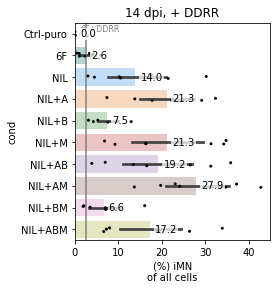

In [ ]:
# General plotting params
y = 'cond'
x = 'percent'
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+A', 'NIL+B', 'NIL+M',
             'NIL+AB', 'NIL+AM', 'NIL+BM', 'NIL+ABM']
palette = {
    'Ctrl-puro':'grey', 'NIL':'dodgerblue', '6F':'teal',
    'NIL+A':'tab:orange', 'NIL+B':'tab:green', 'NIL+M':'tab:red',
    'NIL+AB':'tab:purple', 'NIL+AM':'tab:brown', 'NIL+BM':'tab:pink',
    'NIL+ABM':'tab:olive'}

fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))

# Plot iMN percent of all cells
sns.barplot(ax=ax, data=data_iMN_percent,
            x=x, y=y, order=cond_list,
            alpha=0.3, orient='h', palette=palette)
sns.stripplot(ax=ax, data=data_iMN_percent,
              x=x, y=y, order=cond_list,
              dodge=True, color='black', size=3, orient='h')

# Plot avg for 6F
avg_6FDDRR_iMN_percent = np.mean(
    data_iMN_percent.loc[(data_iMN_percent['cond'] == '6F')]['percent'])
ax.axvline(avg_6FDDRR_iMN_percent, 0, 1, color='grey')
ax.annotate('6F+DDRR', (0.03, 0.96),
    xycoords='axes fraction', ha='left', color='grey', fontsize=8)

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.1f', padding=5)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
ax.set_title('14 dpi, + DDRR')
ax.xaxis.set_label_text('(%) iMN\nof all cells')

Yield

Text(0.5, 0, '(%) iMN yield\nper MEF plated')

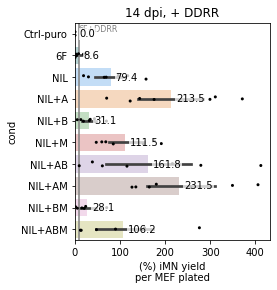

In [ ]:
# General plotting params
y = 'cond'
x = 'yield'
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+A', 'NIL+B', 'NIL+M',
             'NIL+AB', 'NIL+AM', 'NIL+BM', 'NIL+ABM']
palette = {
    'Ctrl-puro':'grey', 'NIL':'dodgerblue', '6F':'teal',
    'NIL+A':'tab:orange', 'NIL+B':'tab:green', 'NIL+M':'tab:red',
    'NIL+AB':'tab:purple', 'NIL+AM':'tab:brown', 'NIL+BM':'tab:pink',
    'NIL+ABM':'tab:olive'}

fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))

# Plot iMN percent of all cells
sns.barplot(ax=ax, data=data_iMN_yield,
            x=x, y=y, order=cond_list,
            alpha=0.3, orient='h', palette=palette)
sns.stripplot(ax=ax, data=data_iMN_yield,
              x=x, y=y, order=cond_list,
              dodge=True, color='black', size=3, orient='h')

# Plot avg for 6F
avg_6FDDRR_iMN_yield = np.mean(
    data_iMN_yield.loc[(data_iMN_yield['cond'] == '6F')][x])
ax.axvline(avg_6FDDRR_iMN_yield, 0, 1, color='grey')
ax.annotate('6F+DDRR', (0.02, 0.96),
    xycoords='axes fraction', ha='left', color='grey', fontsize=8)

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.1f', padding=5)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
ax.set_title('14 dpi, + DDRR')
ax.xaxis.set_label_text('(%) iMN yield\nper MEF plated')

In [27]:
brn2_data_iMN_yield_reps = data_iMN_yield_reps.copy()
brn2_data_iMN_yield_reps.drop(brn2_data_iMN_yield_reps[brn2_data_iMN_yield_reps.cond == 'Ctrl-puro'].index, inplace=True)
brn2_data_iMN_yield_reps.drop(brn2_data_iMN_yield_reps[brn2_data_iMN_yield_reps.cond == '6F'].index, inplace=True)

paired_map = {
    'NIL':('NIL', '– Brn2'),
    'NIL+B':('NIL', '+ Brn2'),
    'NIL+A':('NIL+A', '– Brn2'),
    'NIL+AB':('NIL+A', '+ Brn2'),
    'NIL+M':('NIL+M', '– Brn2'),
    'NIL+BM':('NIL+M', '+ Brn2'),
    'NIL+AM':('NIL+AM', '– Brn2'),
    'NIL+ABM':('NIL+AM', '+ Brn2'),
}

for index, row in brn2_data_iMN_yield_reps.iterrows():
    brn2_data_iMN_yield_reps.loc[index, 'main_cond'] = paired_map[row.cond][0]
    brn2_data_iMN_yield_reps.loc[index, 'Brn2_cat'] = paired_map[row.cond][1]

# Calc mean and SEM for each cond
grouping = ['cond', 'main_cond', 'Brn2_cat']
brn2_data_iMN_yield = brn2_data_iMN_yield_reps.groupby(grouping).mean().reset_index()
brn2_data_iMN_yield_SEM = brn2_data_iMN_yield_reps.groupby(grouping).sem().reset_index()

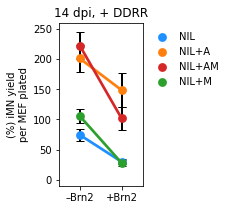

In [29]:
# General plotting params
x = 'Brn2_cat'
y = 'yield'
order = ['NIL', 'NIL+A', 'NIL+M', 'NIL+AM']
hue = 'main_cond'
# palette = {'': 'grey', '+B': 'dodgerblue'}
palette = {
    'NIL':'dodgerblue', 'NIL+A':'tab:orange',
    'NIL+M':'tab:green', 'NIL+AM':'tab:red',}

fig, ax = plt.subplots(1, 1, figsize=(1.5, 3))

sns.pointplot(
    ax=ax, data=brn2_data_iMN_yield_reps,
    x=x, y=y, hue=hue, 
    ci=None,
    palette=palette,
    capsize=0.1, errwidth=2)

ax.errorbar(x=brn2_data_iMN_yield[x], y=brn2_data_iMN_yield[y],
            yerr=brn2_data_iMN_yield_SEM[y],
            color='None', ecolor='black', elinewidth=2, capsize=4, zorder=-1)


sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format
ax.set_title('14 dpi, + DDRR')
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
ax.xaxis.set_label_text('')
ax.set_xlim((-0.5, 1.5)) # f = ax.get_xlim()
ax.set_ylim((-10, 260))

ax.xaxis.set_ticklabels(['–Brn2', '+Brn2'])

# plt.savefig(figpath + '14dpi_iMN_yield_Brn2cat_compact.svg', bbox_inches='tight')

## Look at 4 dpi hyperP vs. iMN

In [30]:
# Copy dataframe of hyperP 4 dpi cells that will integrate with the 14 dpi data and rename column to be clear
data_both_reps = CTFR_hyperP_percent_4dpi_reps.rename(columns={"percent":"4dpi HyperP percent"}, copy=True)
data_both_reps.drop(columns='CTFR_cat', inplace=True)

# Integrate iMN yield and percent into 4 dpi data
for index, row in data_both_reps.iterrows():

    # Get iMN yield
    iMN_yield = data_iMN_yield_reps.loc[
        (data_iMN_yield_reps['rep']==row.rep) & 
        (data_iMN_yield_reps['cond']==row.cond) &
        (data_iMN_yield_reps['well']==row.well)
        ]['yield']
    # Get iMN percent
    iMN_percent = data_iMN_percent_reps.loc[
        (data_iMN_percent_reps['rep']==row.rep) & 
        (data_iMN_percent_reps['cond']==row.cond) &
        (data_iMN_percent_reps['well']==row.well)
        ]['percent']
    # Get hyperP count
    hyperP_count = CTFR_hyperP_count_4dpi_reps.loc[
        (CTFR_hyperP_count_4dpi_reps['rep']==row.rep) & 
        (CTFR_hyperP_count_4dpi_reps['well']==row.well) & 
        (CTFR_hyperP_count_4dpi_reps['cond']==row.cond)
        ]['count']
    # Get hyperP yield
    hyperP_yield = CTFR_hyperP_yield_4dpi_reps.loc[
        (CTFR_hyperP_yield_4dpi_reps['rep']==row.rep) & 
        (CTFR_hyperP_yield_4dpi_reps['well']==row.well) & 
        (CTFR_hyperP_yield_4dpi_reps['cond']==row.cond)
        ]['yield']
    
    # Integrate in
    # If empty (i.e. wells not collected), skip it
    if len(iMN_yield) == 0:
        continue

    data_both_reps.loc[index, 'iMN yield'] = float(iMN_yield)
    data_both_reps.loc[index, 'iMN percent'] = float(iMN_percent)
    data_both_reps.loc[index, '4dpi HyperP count'] = float(hyperP_count)
    data_both_reps.loc[index, '4dpi HyperP yield'] = float(hyperP_yield)

### Selectivity

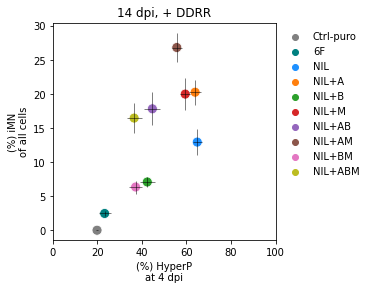

In [ ]:
# Calc mean and SEM for each cond
grouping = ['cond']
data_both_mean = data_both_reps.groupby(grouping).mean().reset_index()
data_both_SEM = data_both_reps.groupby(grouping).sem().reset_index()

# Plotting params
x = '4dpi HyperP percent'
y = 'iMN percent'
hue = 'cond'
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+A', 'NIL+B', 'NIL+M',
             'NIL+AB', 'NIL+AM', 'NIL+BM', 'NIL+ABM']
palette = {
    'Ctrl-puro':'grey', 'NIL':'dodgerblue', '6F':'teal',
    'NIL+A':'tab:orange', 'NIL+B':'tab:green', 'NIL+M':'tab:red',
    'NIL+AB':'tab:purple', 'NIL+AM':'tab:brown', 'NIL+BM':'tab:pink',
    'NIL+ABM':'tab:olive'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.errorbar(x=data_both_mean[x], y=data_both_mean[y],
            xerr=data_both_SEM[x], yerr=data_both_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)
            
f = sns.scatterplot(ax=ax,
    data=data_both_mean,
    x=x, y=y, hue=hue,
    hue_order=cond_list,
    s=100, palette=palette)

sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_xticks(np.arange(0, 110, 20))
ax.xaxis.set_label_text('(%) HyperP\nat 4 dpi')
ax.yaxis.set_label_text('(%) iMN\nof all cells')
plt.title('14 dpi, + DDRR')
ax.yaxis.set_major_formatter(k_formatter)

# plt.savefig(figpath + 'SI/14dpi_iMNpercent_v_hyperPnum.svg', bbox_inches='tight')

## Yield

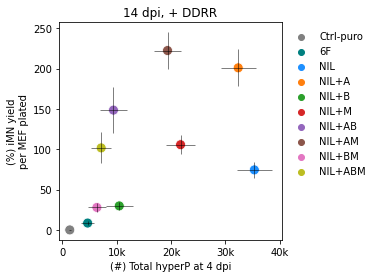

In [ ]:
# Calc mean and SEM for each cond
grouping = ['cond']
data_both_mean = data_both_reps.groupby(grouping).mean().reset_index()
data_both_SEM = data_both_reps.groupby(grouping).sem().reset_index()

# Plotting params
x = '4dpi HyperP count'
y = 'iMN yield'
hue = 'cond'
cond_list = ['Ctrl-puro', '6F', 'NIL',
             'NIL+A', 'NIL+B', 'NIL+M',
             'NIL+AB', 'NIL+AM', 'NIL+BM', 'NIL+ABM']
palette = {
    'Ctrl-puro':'grey', 'NIL':'dodgerblue', '6F':'teal',
    'NIL+A':'tab:orange', 'NIL+B':'tab:green', 'NIL+M':'tab:red',
    'NIL+AB':'tab:purple', 'NIL+AM':'tab:brown', 'NIL+BM':'tab:pink',
    'NIL+ABM':'tab:olive'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.errorbar(x=data_both_mean[x], y=data_both_mean[y],
            xerr=data_both_SEM[x], yerr=data_both_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)
            
f = sns.scatterplot(ax=ax,
    data=data_both_mean,
    x=x, y=y, hue=hue,
    hue_order=cond_list,
    s=100, palette=palette)

sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
# ax.set_xticks(np.arange(0, 110, 20))
ax.xaxis.set_major_formatter(k_formatter)
ax.xaxis.set_label_text('(#) Total hyperP at 4 dpi')
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
plt.title('14 dpi, + DDRR')

# plt.savefig(figpath + '14dpi_iMNyield_v_hyperPcount.svg', bbox_inches='tight')